In [140]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

import os
import io

import datetime

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


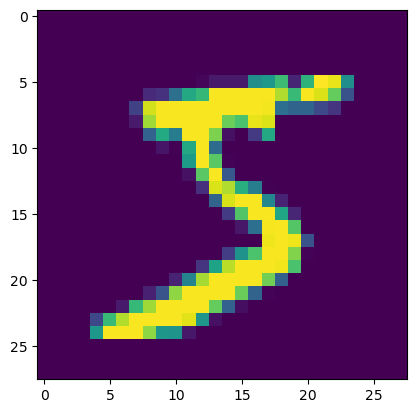

In [141]:
(X_train, Y_train), _ = mnist.load_data()
X_train = (X_train - 127.5) / 127.5
plt.imshow(X_train[0,:,:])

In [142]:
def make_generator(latent_vector_shape):
    latent_input = layers.Input(shape=latent_vector_shape)
    gen = layers.Dense(3*3*latent_vector_shape)(latent_input)
    gen = layers.Reshape((3,3,latent_vector_shape))(gen)
    gen = layers.Dropout(0.2)(gen)
    
    gen = layers.Conv2DTranspose(latent_vector_shape, (2, 2), 2, use_bias=False)(gen)
    gen = layers.ReLU()(gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.Dropout(0.4)(gen)
    #Output: (7, 7, lvs)
    
    gen = layers.Conv2DTranspose(latent_vector_shape/2, (4, 4), 2, use_bias=False)(gen)
    gen = layers.ReLU()(gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.Dropout(0.4)(gen)
    #Output: (14, 14, lvs/2)
    
    gen = layers.Conv2DTranspose(latent_vector_shape/4, (4, 4), 2, use_bias=False)(gen)
    gen = layers.ReLU()(gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.Dropout(0.4)(gen)
    #Output: (28, 28, lvs/4)
    
    out = layers.Conv2D(1, (3, 3), strides=(1,1), activation='tanh')(gen)
    
    model: keras.Model = keras.Model(latent_input, out)
    print(model.output_shape)
    assert model.output_shape == (None, 28, 28, 1)
    return model

generator = make_generator(128)
generator.summary()

(None, 28, 28, 1)
Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 128)]             0         
                                                                 
 dense_52 (Dense)            (None, 1152)              148608    
                                                                 
 reshape_34 (Reshape)        (None, 3, 3, 128)         0         
                                                                 
 dropout_111 (Dropout)       (None, 3, 3, 128)         0         
                                                                 
 conv2d_transpose_100 (Conv2  (None, 6, 6, 128)        65536     
 DTranspose)                                                     
                                                                 
 re_lu_100 (ReLU)            (None, 6, 6, 128)         0         
                                        

In [143]:
def make_discriminator(input_shape):
    image_input = layers.Input(input_shape)
    
    disc = layers.Conv2D(32, (3, 3))(image_input)
    disc = layers.AveragePooling2D()(disc)
    disc = layers.LeakyReLU(alpha=0.02)(disc)
    disc = layers.BatchNormalization()(disc)
    
    disc = layers.Conv2D(64, (3, 3))(disc)
    disc = layers.AveragePooling2D()(disc)
    disc = layers.LeakyReLU(alpha=0.02)(disc)
    
    disc = layers.Conv2D(64, (3, 3))(disc)
    disc = layers.AveragePooling2D()(disc)
    disc = layers.LeakyReLU(alpha=0.02)(disc)
    
    disc = layers.Flatten()(disc)
    disc = layers.Dropout(0.3)(disc)
    disc = layers.Dense(30)(disc)
    out = layers.Dense(1)(disc)
    
    model = keras.Model(image_input, out)
    
    return model

discriminator = make_discriminator((28, 28, 1))
discriminator.summary()

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_58 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 average_pooling2d_24 (Avera  (None, 13, 13, 32)       0         
 gePooling2D)                                                    
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 13, 13, 32)        0         
                                                                 
 batch_normalization_111 (Ba  (None, 13, 13, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_59 (Conv2D)          (None, 11, 11, 64)        184

In [144]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim=128, disc_extra_steps=3):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = disc_extra_steps
        self.noiseLayer = layers.GaussianNoise(0.2)
        
    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def train_step(self, images):
        batch_size = tf.shape(images)[0]
        
        for i in range(self.d_steps):
            latent_vector = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as gt:
                generated_images = self.generator(latent_vector, training=True)
                noisy_generated_images = self.noiseLayer(generated_images, training=False) 
                prediction_fake = self.discriminator(generated_images, training=True)
                
                noisy_images = self.noiseLayer(images, training=False)
                prediction_real = self.discriminator(noisy_images, training=True)
                
                d_loss = self.d_loss_fn(prediction_real, prediction_fake)
            d_gradients = gt.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))
            
            latent_vector = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as gt:
                generated_images = self.generator(latent_vector, training=True)
                prediction_fake = self.discriminator(generated_images, training=True)
                g_loss = self.g_loss_fn(prediction_fake)
                
            g_gradients = gt.gradient(g_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
            
        return {"d_loss": d_loss, "g_loss": g_loss}

In [145]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [146]:
log_dir = "mnistGAN/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
img_log_dir = "mnistGAN/logs/images/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

file_writer = tf.summary.create_file_writer(img_log_dir)

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image


class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=16, latent_dim=100):
        self.num_img = num_img
        self.seed = random_latent_vectors = tf.random.normal(shape=(num_img, latent_dim))
    
    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed, training=False)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images = generated_images.numpy()
        
        fig = plt.figure(figsize=(4, 4))
    
        for i in range(generated_images.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(generated_images[i, :, :, :].astype("int32"))
            plt.axis('off')

        plt.savefig(os.path.join("mnistGAN/", "images/",'image_at_epoch_{:04d}.png'.format(epoch)))
        with file_writer.as_default():
            tf.summary.image("Output", plot_to_image(fig), step=epoch)

ick = GANMonitor(num_img=16, latent_dim=128)


In [147]:
gan = GAN(discriminator, generator)
gan.compile(discriminator_optimizer, generator_optimizer, discriminator_loss, generator_loss)

In [148]:
%tensorboard --logdir mnistGAN/logs
gan.fit(X_train, epochs=50, batch_size=256, callbacks=[ick, tensorboard_callback])

Epoch 1/50
235/235 [==============================] - 19s 65ms/step - d_loss: 0.2863 - g_loss: 3.3794
Epoch 2/50
235/235 [==============================] - 15s 65ms/step - d_loss: 0.3874 - g_loss: 3.0467
Epoch 3/50
235/235 [==============================] - 15s 64ms/step - d_loss: 0.4302 - g_loss: 2.9321
Epoch 4/50
235/235 [==============================] - 15s 64ms/step - d_loss: 0.4745 - g_loss: 2.8113
Epoch 5/50
235/235 [==============================] - 15s 66ms/step - d_loss: 0.4993 - g_loss: 2.7051
Epoch 6/50
235/235 [==============================] - 16s 70ms/step - d_loss: 0.5360 - g_loss: 2.5445
Epoch 7/50
235/235 [==============================] - 15s 65ms/step - d_loss: 0.5680 - g_loss: 2.4261
Epoch 8/50
235/235 [==============================] - 15s 64ms/step - d_loss: 0.6122 - g_loss: 2.2588
Epoch 9/50
235/235 [==============================] - 15s 65ms/step - d_loss: 0.6505 - g_loss: 2.1425
Epoch 10/50
235/235 [==============================] - 15s 65ms/step - d_loss: 0.6

(100, 28, 28, 1)


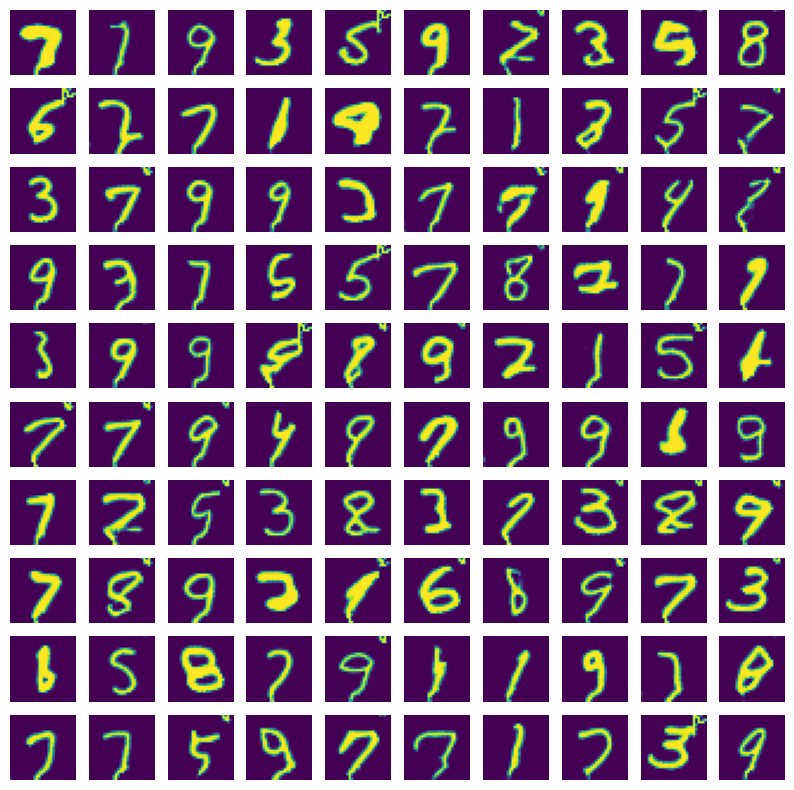

In [161]:
images = 25
predictions = np.empty([100,28,28,1])
for i in range(4):
    seed = tf.random.normal([images, 128])
    label_seed = np.random.randint(0,2, images)
    pred = generator(seed, training=False).numpy()
    predictions[25*i:25*(i+1), :, :, :] = pred
    
print(predictions.shape)
figsize = 10
fig = plt.figure(figsize=(figsize, figsize))  
for i in range(predictions.shape[0]):
    plt.subplot(figsize, figsize, i+1)
    plt.imshow((predictions[i, :, :, :]*127.5+127.5).astype("int32"))
    plt.axis('off')
plt.show()